In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
%config Completer.use_jedi = False

# Booking Hotels Dataset

Here we have a dataset containing 524 unique hotels.
The columns are:

Index

Name - Hotel Name

Place - Place of hotel

Type - Type of hotel

Price - Price for 2 people

ReviewsCount - Total reviews count

Ratings - Ratings out of 10

City - City in which the hotel is located

State - State in which the hotel is located

With all of the geographical data and the description, we can ask ourselves if one can predict the price of the hotel.
We have here a regression problem.

# Data Loading

In [4]:
df=pd.read_excel('HotelFinalDataset.xlsx')

We can remove the first column as it is the same as the index of the dataset.
The place column is also redundant with the City and State columns

In [5]:
df = df.drop(['Unnamed: 0', 'Place'], axis=1)

In [6]:
df

,Name,Type,Price,ReviewsCount,Rating,City,State
0,BUNK Hotel Amsterdam,Bunk Pod for 2,"₹ 7,887",778.0,8.4,Amsterdam Noord,Amsterdam
1,YOTEL Amsterdam,Premium Double Room,"₹ 15,267",500.0,8.1,Amsterdam Noord,Amsterdam
2,Multatuli Hotel,Double Room,"₹ 13,063",1605.0,7.4,Amsterdam City Center,Amsterdam
3,nhow Amsterdam Rai,nhow Double or Twin Room with View,"₹ 12,854",500.0,9.0,Zuideramstel,Amsterdam
4,Motel One Amsterdam,Double Room,"₹ 9,471",500.0,8.8,Zuideramstel,Amsterdam
...,...,...,...,...,...,...,...
520,Stadslogement Bij de Sassenpoort,Superior Apartment,"₹ 8,899",232.0,8.4,Zwolle,NaN
521,Mercure Hotel Zwolle,Standard Double Room,"₹ 10,205",1402.0,7.7,Zwolle,NaN
522,The Cabin at Zwolle Centraal,Double Room with Private Bathroom,"₹ 6,123",149.0,7.2,Zwolle,NaN
523,Hanze Hotel Zwolle,Standard Twin Room,"₹ 7,789",1095.0,7.2,Zwolle,NaN


We can see that we don't seem to have many features to work with. We will have to create more

# Data preparation And Feature Engineering

In [7]:
df.isna().sum()


Name              0
Type              0
Price             0
ReviewsCount     13
Rating           10
City              0
State           392
dtype: int64

There are NaN values in multiple columns. We will remove rows with NaN values in ReviewsCount and Rating. For State we'll use one hot vectors

In [8]:
df = df[df['ReviewsCount'].notna() & df['Rating'].notna()]


In [9]:
df.groupby('Type').Name.count()

Type
 Deluxe double or Twin Room                       1
1 Queen or King Bed Essential Room                1
2-person Premium Hotelroom                        1
6 Person Room with Private Bathroom and Shower    1
Apartment                                         2
                                                 ..
Two-Bedroom Chalet                                3
Two-Bedroom House                                 6
Two-Bedroom Suite                                 1
bunk                                              1
nhow Double or Twin Room with View                1
Name: Name, Length: 187, dtype: int64

There are many different types of housing. We'll take into account the words that come up often in the description.

In [10]:
data_set = df.Type.values

In [11]:
data_set = list(data_set)

In [12]:
data_set = ' '.join(data_set)

In [13]:
#here we'll output the ten most common words in the Type column
from collections import Counter
split_str = data_set.split()
  
Counter = Counter(split_str)

common = Counter.most_common(10)
  
print(common)

[('Room', 356), ('Double', 214), ('Twin', 102), ('with', 85), ('Standard', 79), ('Deluxe', 65), ('Apartment', 50), ('Comfort', 47), ('Bathroom', 35), ('One-Bedroom', 32)]


In [14]:
#We can get a list of columns to add to our dataset and make one hot vectors for the types
types = []
for tup in common:
    types.append(tup[0].lower())

In [15]:
print(types)

['room', 'double', 'twin', 'with', 'standard', 'deluxe', 'apartment', 'comfort', 'bathroom', 'one-bedroom']


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
pattern = "(?u)\\b[\\w-]+\\b"
cv = CountVectorizer(vocabulary=types, token_pattern=pattern)

one_hot = pd.DataFrame(cv.fit_transform(df['Type']).todense(), 
                   df.index,
                   cv.get_feature_names())

In [17]:
one_hot

,room,double,twin,with,standard,deluxe,apartment,comfort,bathroom,one-bedroom
0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
520,0,0,0,0,0,0,1,0,0,0
521,1,1,0,0,1,0,0,0,0,0
522,1,1,0,1,0,0,0,0,1,0
523,1,0,1,0,1,0,0,0,0,0


In [18]:
#we convert data types for the columns
one_hot = one_hot.apply(pd.to_numeric)

In [19]:
df = df.join(one_hot)

In [20]:
df

,Name,Type,Price,ReviewsCount,Rating,City,State,room,double,twin,with,standard,deluxe,apartment,comfort,bathroom,one-bedroom
0,BUNK Hotel Amsterdam,Bunk Pod for 2,"₹ 7,887",778.0,8.4,Amsterdam Noord,Amsterdam,0,0,0,0,0,0,0,0,0,0
1,YOTEL Amsterdam,Premium Double Room,"₹ 15,267",500.0,8.1,Amsterdam Noord,Amsterdam,1,1,0,0,0,0,0,0,0,0
2,Multatuli Hotel,Double Room,"₹ 13,063",1605.0,7.4,Amsterdam City Center,Amsterdam,1,1,0,0,0,0,0,0,0,0
3,nhow Amsterdam Rai,nhow Double or Twin Room with View,"₹ 12,854",500.0,9.0,Zuideramstel,Amsterdam,1,1,1,1,0,0,0,0,0,0
4,Motel One Amsterdam,Double Room,"₹ 9,471",500.0,8.8,Zuideramstel,Amsterdam,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,Stadslogement Bij de Sassenpoort,Superior Apartment,"₹ 8,899",232.0,8.4,Zwolle,NaN,0,0,0,0,0,0,1,0,0,0
521,Mercure Hotel Zwolle,Standard Double Room,"₹ 10,205",1402.0,7.7,Zwolle,NaN,1,1,0,0,1,0,0,0,0,0
522,The Cabin at Zwolle Centraal,Double Room with Private Bathroom,"₹ 6,123",149.0,7.2,Zwolle,NaN,1,1,0,1,0,0,0,0,1,0
523,Hanze Hotel Zwolle,Standard Twin Room,"₹ 7,789",1095.0,7.2,Zwolle,NaN,1,0,1,0,1,0,0,0,0,0


In [21]:
df = df.drop(['Type'], axis=1)

In [22]:
#removing the currency symbol
df['Price'] = df['Price'].str.replace('₹', '')
df['Price'] = df['Price'].str.replace(',', '.')
df['Price'] = df['Price'].astype(float)

In [23]:
#one-hots for City
cities = pd.get_dummies(df['City'])
#one-hots for State
states =pd.get_dummies(df['State']) 

In [24]:
df = df.join(cities)
df = df.join(states)

In [25]:
df

,Name,Price,ReviewsCount,Rating,City,State,room,double,twin,with,...,Zuid,Zuideramstel,Zuidwest,Zwolle,Amsterdam,Eindhoven,Maastricht,Rotterdam,The Hague,Utrecht
0,BUNK Hotel Amsterdam,7.887,778.0,8.4,Amsterdam Noord,Amsterdam,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,YOTEL Amsterdam,15.267,500.0,8.1,Amsterdam Noord,Amsterdam,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,Multatuli Hotel,13.063,1605.0,7.4,Amsterdam City Center,Amsterdam,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,nhow Amsterdam Rai,12.854,500.0,9.0,Zuideramstel,Amsterdam,1,1,1,1,...,0,1,0,0,1,0,0,0,0,0
4,Motel One Amsterdam,9.471,500.0,8.8,Zuideramstel,Amsterdam,1,1,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,Stadslogement Bij de Sassenpoort,8.899,232.0,8.4,Zwolle,NaN,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
521,Mercure Hotel Zwolle,10.205,1402.0,7.7,Zwolle,NaN,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
522,The Cabin at Zwolle Centraal,6.123,149.0,7.2,Zwolle,NaN,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
523,Hanze Hotel Zwolle,7.789,1095.0,7.2,Zwolle,NaN,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [26]:
Names = df['Name']
df = df.drop(['Name', 'City', 'State'], axis=1)

<AxesSubplot:>

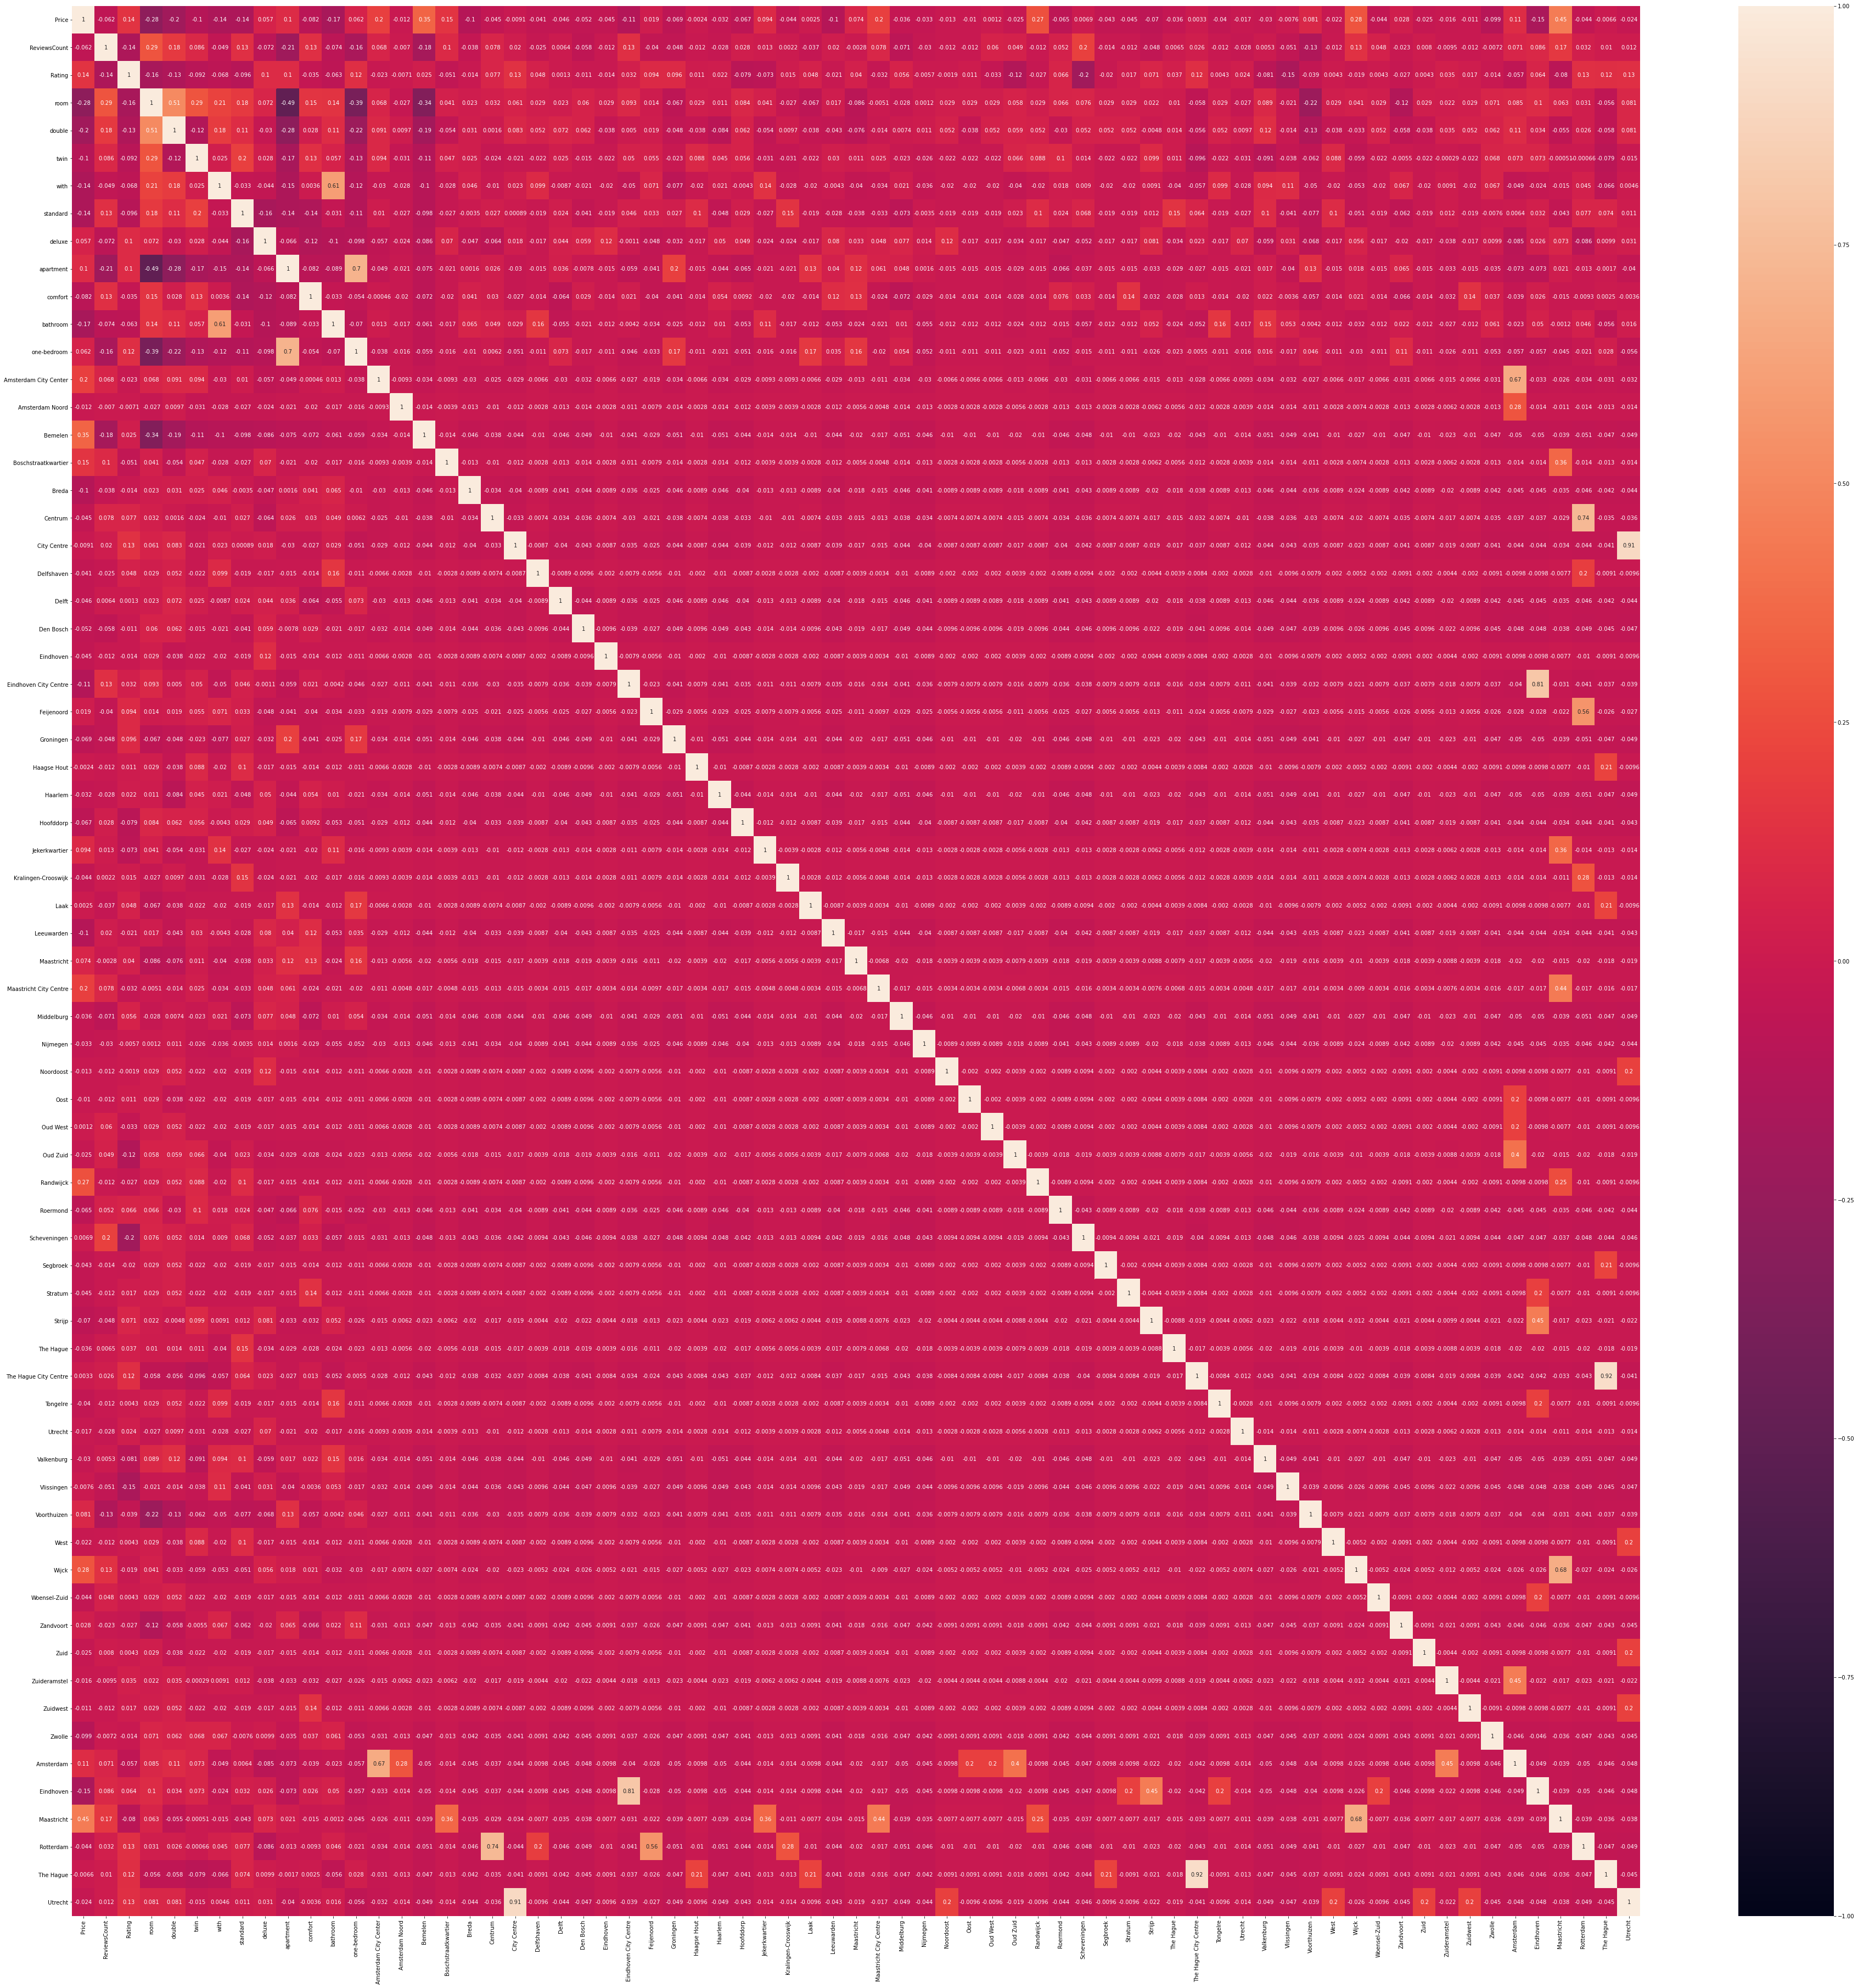

In [27]:
#We can create a heatmap to visualise correlations 
plt.figure(figsize=(64, 64))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

In [28]:
df

,Price,ReviewsCount,Rating,room,double,twin,with,standard,deluxe,apartment,...,Zuid,Zuideramstel,Zuidwest,Zwolle,Amsterdam,Eindhoven,Maastricht,Rotterdam,The Hague,Utrecht
0,7.887,778.0,8.4,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,15.267,500.0,8.1,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,13.063,1605.0,7.4,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,12.854,500.0,9.0,1,1,1,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,9.471,500.0,8.8,1,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,8.899,232.0,8.4,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
521,10.205,1402.0,7.7,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
522,6.123,149.0,7.2,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
523,7.789,1095.0,7.2,1,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


We now have a lot more columns to work with

# Some Statistics

In [29]:
df[['Price', 'ReviewsCount', 'Rating']].describe()

,Price,ReviewsCount,Rating
count,512.000000,512.000000,512.000000
mean,12.812465,736.556641,8.330273
std,6.514815,879.553639,0.713554
min,3.988000,1.000000,3.700000
25%,8.693000,239.000000,8.000000
50%,11.199500,500.000000,8.400000
75%,14.288000,888.000000,8.800000
max,53.439000,7748.000000,10.000000


For example the mean rating is 8.331456. We can see that we have outliers in the Price and ReviewsCount column. We can remove them

In [30]:
q_low = df['Price'].quantile(0.01)
q_hi  = df['Price'].quantile(0.99)

df = df[(df['Price'] < q_hi) & (df['Price'] > q_low)]

In [31]:
q_low = df['ReviewsCount'].quantile(0.01)
q_hi  = df['ReviewsCount'].quantile(0.99)

df= df[(df['ReviewsCount'] < q_hi) & (df['ReviewsCount'] > q_low)]

In [32]:
df[['Price', 'ReviewsCount', 'Rating']].describe()

,Price,ReviewsCount,Rating
count,480.000000,480.000000,480.000000
mean,12.336273,712.081250,8.345208
std,5.360811,733.011342,0.690268
min,5.364000,2.000000,3.700000
25%,8.741250,266.500000,8.000000
50%,11.022000,500.000000,8.400000
75%,13.883250,888.000000,8.800000
max,34.428000,3803.000000,9.800000


In [33]:
df.groupby('deluxe').Rating.mean()

deluxe
0    8.316587
1    8.531250
Name: Rating, dtype: float64

deluxe rooms are rated higher, this confirms our intuition.

In [34]:
df=(df-df.mean())/df.std()

In [35]:
print(df.isna().sum().to_string())

Price                       0
ReviewsCount                0
Rating                      0
room                        0
double                      0
twin                        0
with                        0
standard                    0
deluxe                      0
apartment                   0
comfort                     0
bathroom                    0
one-bedroom                 0
Amsterdam City Center       0
Amsterdam Noord             0
Bemelen                     0
Boschstraatkwartier         0
Breda                       0
Centrum                     0
City Centre                 0
Delfshaven                  0
Delft                       0
Den Bosch                   0
Eindhoven                   0
Eindhoven City Centre       0
Feijenoord                  0
Groningen                   0
Haagse Hout                 0
Haarlem                     0
Hoofddorp                   0
Jekerkwartier               0
Kralingen-Crooswijk         0
Laak                        0
Leeuwarden

In [36]:
df

,Price,ReviewsCount,Rating,room,double,twin,with,standard,deluxe,apartment,...,Zuid,Zuideramstel,Zuidwest,Zwolle,Amsterdam,Eindhoven,Maastricht,Rotterdam,The Hague,Utrecht
0,-0.829963,0.089929,0.079377,-1.580737,-0.873563,-0.515689,-0.453432,-0.436657,-0.391823,-0.321299,...,-0.045644,-0.102491,-0.045644,-0.213673,4.452883,-0.21894,-0.166671,-0.224106,-0.213673,-0.224106
1,0.546695,-0.289329,-0.355237,0.618549,1.142352,-0.515689,-0.453432,-0.436657,-0.391823,-0.321299,...,-0.045644,-0.102491,-0.045644,-0.213673,4.452883,-0.21894,-0.166671,-0.224106,-0.213673,-0.224106
2,0.135563,1.218151,-1.369336,0.618549,1.142352,-0.515689,-0.453432,-0.436657,-0.391823,-0.321299,...,-0.045644,-0.102491,-0.045644,-0.213673,4.452883,-0.21894,-0.166671,-0.224106,-0.213673,-0.224106
3,0.096576,-0.289329,0.948605,0.618549,1.142352,1.935112,2.200806,-0.436657,-0.391823,-0.321299,...,-0.045644,9.736636,-0.045644,-0.213673,4.452883,-0.21894,-0.166671,-0.224106,-0.213673,-0.224106
4,-0.534485,-0.289329,0.658863,0.618549,1.142352,-0.515689,-0.453432,-0.436657,-0.391823,-0.321299,...,-0.045644,9.736636,-0.045644,-0.213673,4.452883,-0.21894,-0.166671,-0.224106,-0.213673,-0.224106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,-0.641185,-0.654944,0.079377,-1.580737,-0.873563,-0.515689,-0.453432,-0.436657,-0.391823,3.105886,...,-0.045644,-0.102491,-0.045644,4.670290,-0.224106,-0.21894,-0.166671,-0.224106,-0.213673,-0.224106
521,-0.397565,0.941212,-0.934722,0.618549,1.142352,-0.515689,-0.453432,2.285358,-0.391823,-0.321299,...,-0.045644,-0.102491,-0.045644,4.670290,-0.224106,-0.21894,-0.166671,-0.224106,-0.213673,-0.224106
522,-1.159017,-0.768175,-1.659078,0.618549,1.142352,-0.515689,2.200806,-0.436657,-0.391823,-0.321299,...,-0.045644,-0.102491,-0.045644,4.670290,-0.224106,-0.21894,-0.166671,-0.224106,-0.213673,-0.224106
523,-0.848243,0.522391,-1.659078,0.618549,-0.873563,1.935112,-0.453432,2.285358,-0.391823,-0.321299,...,-0.045644,-0.102491,-0.045644,4.670290,-0.224106,-0.21894,-0.166671,-0.224106,-0.213673,-0.224106


In [37]:
df = df.drop('Randwijck', axis=1)

# Training

Now that we have a usable dataset we can make models using popular regression algorithms

In [38]:
random_state = 0

#We prepare the test and training sets
X = df.drop(['Price'],axis = 1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



# First method : Linear Regression

In [39]:
#We use a linear regression first as a baseline method

model_1 = LinearRegression()
cv = 4 #number of folds
print("R2:")
print(cross_val_score(model_1, X_train.values, y_train.values, cv=cv).mean())
print("MSE:")
print(cross_val_score(model_1, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error').mean())

R2:
-7.098898396285723e+27
MSE:
-6.187011443585278e+27


In [40]:
model_1 = model_1.fit(X_train.values, y_train.values)
y_test_pred = model_1.predict(X_test.values)
xmin= min(y_test.min(), y_test_pred.min() )-1
xmax= max(y_test.max(), y_test_pred.max() )+1

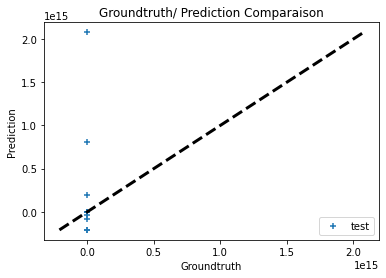

In [41]:
fig = plt.figure(1)
plt.scatter(y_test,y_test_pred, marker='+', label='test')
plt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1

plt.xlabel('Groundtruth')
plt.ylabel('Prediction') 
plt.title('Groundtruth/ Prediction Comparaison')
plt.legend()
plt.savefig('LR.png')


With this graph we can see how well our model is doing. The black line corresponds to the equation y=x.
Thus, points on the line are perfectly predicted. Points that are far from the line come from a bad prediction.

We get a bad score. Let's test other algorithms : 

# Second method : Random Forest

Trees algorithms work well on structured tabular data. We can start by using a Random Forest model 

In [42]:
model_2 = RandomForestRegressor(random_state= random_state)
print("R2:")
print(cross_val_score(model_2, X_train.values, y_train.values, cv=cv).mean())
print("MSE:")
print(-cross_val_score(model_2, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error').mean())

R2:
0.2737578129129209
MSE:
0.6058210845891698


In [43]:
model_2 = model_2.fit(X_train.values, y_train.values)
y_test_pred = model_2.predict(X_test.values)
xmin= min(y_test.min(), y_test_pred.min() )-1
xmax= max(y_test.max(), y_test_pred.max() )+1

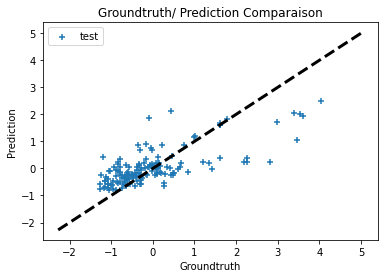

In [44]:
fig = plt.figure(1)
plt.scatter(y_test,y_test_pred, marker='+', label='test')
plt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1

plt.xlabel('Groundtruth')
plt.ylabel('Prediction') 
plt.title('Groundtruth/ Prediction Comparaison')
plt.legend()
plt.savefig('RF.png')


We can try another method

# Third Method : Gradient Boosting

In [45]:
model_3 = GradientBoostingRegressor(random_state= random_state)
print("R2:")
print(cross_val_score(model_3, X_train.values, y_train.values, cv=cv).mean())
print("MSE:")
print(-cross_val_score(model_3, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error').mean())

R2:
0.23588808016145982
MSE:
0.6286692366667721


In [46]:
model_3 = model_3.fit(X_train.values, y_train.values)
y_test_pred = model_3.predict(X_test.values)
xmin= min(y_test.min(), y_test_pred.min() )-1
xmax= max(y_test.max(), y_test_pred.max() )+1

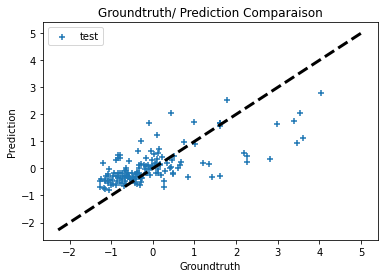

In [47]:
fig = plt.figure(1)
plt.scatter(y_test,y_test_pred, marker='+', label='test')
plt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1

plt.xlabel('Groundtruth')
plt.ylabel('Prediction') 
plt.title('Groundtruth/ Prediction Comparaison')
plt.legend()
plt.savefig('XGB.png')


The last two algorithms seem to be promosing 

# Hyperparameters Optimization

We'll use a gridsearch to optimize the hyperparameters of the last two models

In [48]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {

    'n_estimators': [100, 150, 200, 400, 500]
}
# Create a based model
rf = RandomForestRegressor(random_state= random_state)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = cv, n_jobs = -1, verbose = 2)

In [49]:
grid_search.fit(X_train.values, y_train.values)
best_grid = grid_search.best_estimator_


Fitting 4 folds for each of 5 candidates, totalling 20 fits


In [50]:
print("R2:")
print(cross_val_score(best_grid, X_train.values, y_train.values, cv=cv).mean())
print("MSE:")
print(-cross_val_score(best_grid, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error').mean())

R2:
0.27680561139453896
MSE:
0.6060458480347982


In [51]:
grid_search.best_params_

{'n_estimators': 200}

In [52]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {

    'n_estimators': [10, 20, 30, 50, 70, 100]
}
# Create a based model
rf = GradientBoostingRegressor(random_state= random_state)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = cv, n_jobs = -1, verbose = 2)

In [53]:
grid_search.fit(X_train.values, y_train.values)
best_grid = grid_search.best_estimator_


Fitting 4 folds for each of 6 candidates, totalling 24 fits


In [54]:
print("R2:")
print(cross_val_score(best_grid, X_train.values, y_train.values, cv=cv).mean())
print("MSE:")
print(-cross_val_score(best_grid, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error').mean())

R2:
0.24272276724568595
MSE:
0.6280302351522266


In [55]:
grid_search.best_params_

{'n_estimators': 70}

# Conclusion

our best model is the random forest with 200 estimators. We get a R2 of 0.2748245953984121 and a MSE of 0.6076509818646378.
This is an encouraging result considering the small size of our dataset.